<a href="https://colab.research.google.com/github/Mesut16/Bitirme_Projesi/blob/main/RBF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/gdrive')

import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os

Mounted at /gdrive


In [4]:
data_dir = '/gdrive/My Drive/Retinal Imaging/Eyes'

data_path = "/gdrive/My Drive/Retinal Imaging/Eyes"
cataract_path = os.path.join(data_path, "Cataract")
diabetic_path = os.path.join(data_path, "Diabetic Retinopathy")
glaucoma_path = os.path.join(data_path, "Glaucoma")
normal_path = os.path.join(data_path, "Normal")

print(os.listdir("/gdrive/My Drive/Retinal Imaging/Eyes"))

['Normal', 'Diabetic Retinopathy', 'Glaucoma', 'Cataract']


In [7]:
normals = os.listdir(normal_path)
cataracts = os.listdir(cataract_path)
diabetics = os.listdir(diabetic_path)
glaucomas = os.listdir(glaucoma_path)
print('Total number of normal images:',len(normals))
print('Total number of cataract images:',len(cataracts))
print('Total number of diabetic retinopathy images:',len(diabetics))
print('Total number of glaucoma images:',len(glaucomas))


Total number of normal images: 1074
Total number of cataract images: 1038
Total number of diabetic retinopathy images: 1098
Total number of glaucoma images: 1007


In [8]:
eye_normal = [normal for normal in normals]
eye_cataract = [cataract for cataract in cataracts]
eye_diabetic = [diabetic for diabetic in diabetics]
eye_glaucoma = [glaucoma for glaucoma in glaucomas]

Image 2542_left.jpg is normal eye X-Ray.


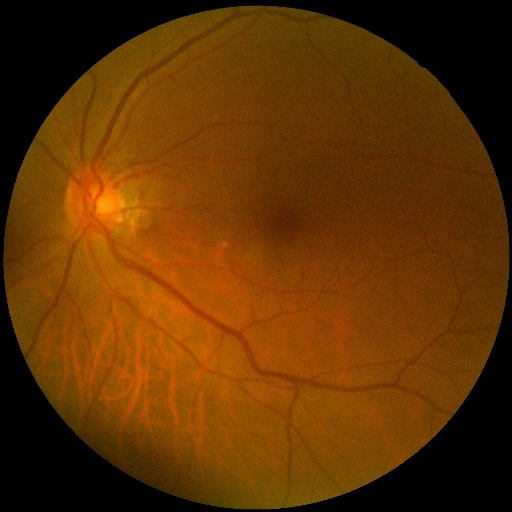

Image _211_9288352.jpg is cataract eye X-Ray.


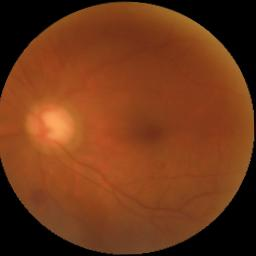

Image 10242_right.jpeg is diabetic retinopathy eye X-Ray.


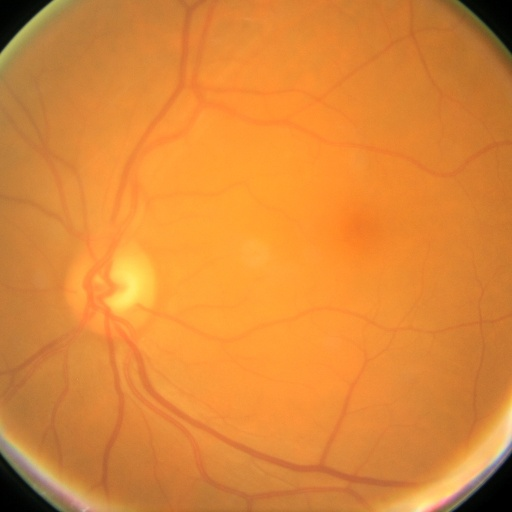

Image _371_5633932.jpg is glaucoma eye X-Ray.


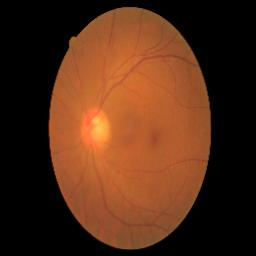

In [9]:
from IPython.display import Image
normal_image = np.random.choice(eye_normal,1)
cataract_image = np.random.choice(eye_cataract,1)
diabetic_image = np.random.choice(eye_diabetic,1)
glaucoma_image = np.random.choice(eye_glaucoma,1)

print("Image %s is normal eye X-Ray." % normal_image[0])
display(Image(os.path.join(data_path, "Normal",normal_image[0]),width=256,height=256))

print("Image %s is cataract eye X-Ray." % cataract_image[0])
display(Image(os.path.join(data_path, "Cataract",cataract_image[0]),width=256,height=256))

print("Image %s is diabetic retinopathy eye X-Ray." % diabetic_image[0])
display(Image(os.path.join(data_path, "Diabetic Retinopathy",diabetic_image[0]),width=256,height=256))

print("Image %s is glaucoma eye X-Ray." % glaucoma_image[0])
display(Image(os.path.join(data_path, "Glaucoma",glaucoma_image[0]),width=256,height=256))



In [10]:
from tensorflow.keras.preprocessing import image

# ResNet model
base_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False
)

model = tf.keras.models.Model(
    inputs=base_model.input,
    outputs=base_model.output
)


94765736/94765736 [==============================] - 0s 0us/step


In [11]:
# Add image paths and tags to the list
image_paths = []
labels = []

for class_name in os.listdir(data_path):
    class_path = os.path.join(data_path, class_name)
    for image_name in os.listdir(class_path):
        image_path = os.path.join(class_path, image_name)
        image_paths.append(image_path)
        labels.append(class_name)

# Add data to a data frame
data_df = pd.DataFrame({'image_path': image_paths, 'label': labels})


In [12]:
# Resume feature extraction
feature_vectors = []
for img_path in data_df['image_path']:
    img = image.load_img(img_path, target_size=(50, 50))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.resnet.preprocess_input(img_array)
    features = model.predict(img_array)
    feature_vectors.append(features.flatten())



1/1 [==============================] - 0s 77ms/step


In [13]:
# Add feature vectors to a data frame
feature_df = pd.DataFrame(feature_vectors)
data_df = pd.concat([data_df, feature_df], axis=1)


In [14]:
# Display results
print(data_df.head())

model.summary()


                                          image_path   label    0         1  \
0  /gdrive/My Drive/Retinal Imaging/Eyes/Normal/2...  Normal  0.0  4.635882   
1  /gdrive/My Drive/Retinal Imaging/Eyes/Normal/2...  Normal  0.0  0.960338   
2  /gdrive/My Drive/Retinal Imaging/Eyes/Normal/2...  Normal  0.0  1.663691   
3  /gdrive/My Drive/Retinal Imaging/Eyes/Normal/2...  Normal  0.0  1.897120   
4  /gdrive/My Drive/Retinal Imaging/Eyes/Normal/2...  Normal  0.0  2.272704   

          2    3         4    5         6         7  ...      8182      8183  \
0  0.000000  0.0  0.000000  0.0  0.107824  0.000000  ...  0.000000  0.000000   
1  0.557368  0.0  0.000000  0.0  0.000000  1.494143  ...  1.006186  0.000000   
2  0.337700  0.0  0.000000  0.0  0.000000  1.143419  ...  0.000000  2.104781   
3  0.000000  0.0  0.400106  0.0  1.883502  0.000000  ...  0.415558  0.000000   
4  1.517403  0.0  0.000000  0.0  2.942775  0.000000  ...  0.000000  0.000000   

   8184  8185      8186  8187  8188      818

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

# Separating data into feature vectors and labels
X = data_df.drop(['image_path', 'label'], axis=1)
y = data_df['label']


In [16]:
# Separation into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [17]:
# Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Create and train an SVM model with RBF kernel
svm_model = SVC(kernel='rbf', C=1.0, probability=True)
svm_model.fit(X_train, y_train)


SVC(probability=True)

In [18]:
# Evaluation of the model
y_pred = svm_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.8187203791469194

Classification Report:
                       precision    recall  f1-score   support

            Cataract       0.82      0.89      0.85       196
Diabetic Retinopathy       0.95      0.90      0.92       220
            Glaucoma       0.69      0.69      0.69       183
              Normal       0.81      0.79      0.80       245

            accuracy                           0.82       844
           macro avg       0.82      0.82      0.82       844
        weighted avg       0.82      0.82      0.82       844



In [19]:
# Cross-validation
from sklearn.model_selection import cross_val_score, StratifiedKFold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(estimator=svm_model, X=X_train, y=y_train, cv=cv, scoring='accuracy')
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())


Cross-validation scores: [0.80740741 0.82962963 0.81481481 0.8041543  0.83827893]
Mean accuracy: 0.8188570172546434


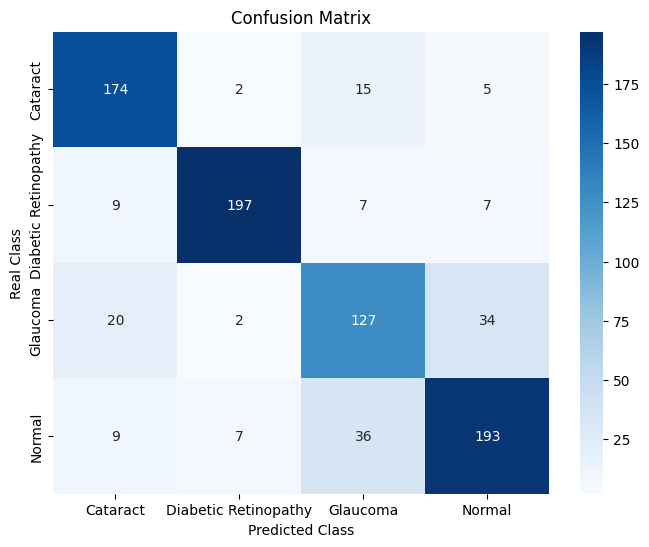

In [22]:
from sklearn.metrics import confusion_matrix

# Confusion matrix creation
cm = confusion_matrix(y_test, y_pred)

# Confusion matrix visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.title('Confusion Matrix')
plt.show()
